In [ ]:
#core
library(dplyr)
library(tidyverse)

#plotting
library(gridExtra)
library(ggplot2)
library(showtext)
library(LTXplot)

#load fonts
load_theme_ltx()

#controls output figure size
fig <- function(width, heigth){
 options(repr.plot.width = width, repr.plot.height = heigth)
 }

In [ ]:
#change to code cell when running in snakemake
df <- read.table(snakemake@input,sep="\t", header=FALSE)
boot_CI_path <- snakemake@output[[1]]
dst_path <- snakemake@output[[2]]

In [2]:
colnames(df) <- c("group","alpha", "omega","pFDM", "NeS_0_1", "NeS_1_10", "NeS_10_100", "NeS_100_99")

In [3]:
df[1:4,]

,group,alpha,omega,pFDM,NeS_0_1,NeS_1_10,NeS_10_100,NeS_100_99
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,candidate,0.324863,0.103049,0.001080079,0.227899,0.059935,0.075697,0.636469
2,noncandidate,0.295857,0.096614,0.001158049,0.244225,0.061753,0.077366,0.616656
3,candidate,0.292246,0.092086,0.001120324,0.235477,0.052494,0.064196,0.647833
4,noncandidate,0.284809,0.093624,0.002839404,0.247595,0.052212,0.063222,0.636970


## Compare alpha, omega-alpha, and DFE between candidate and non-candidate genes

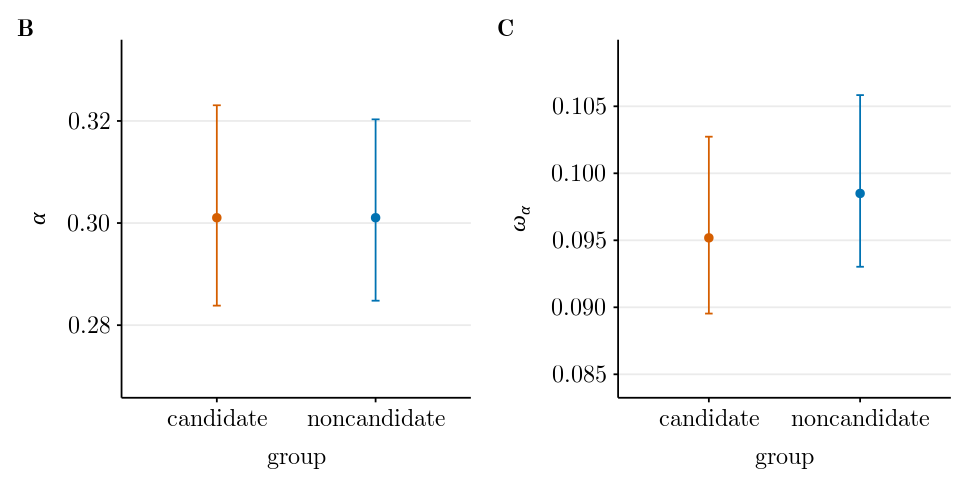

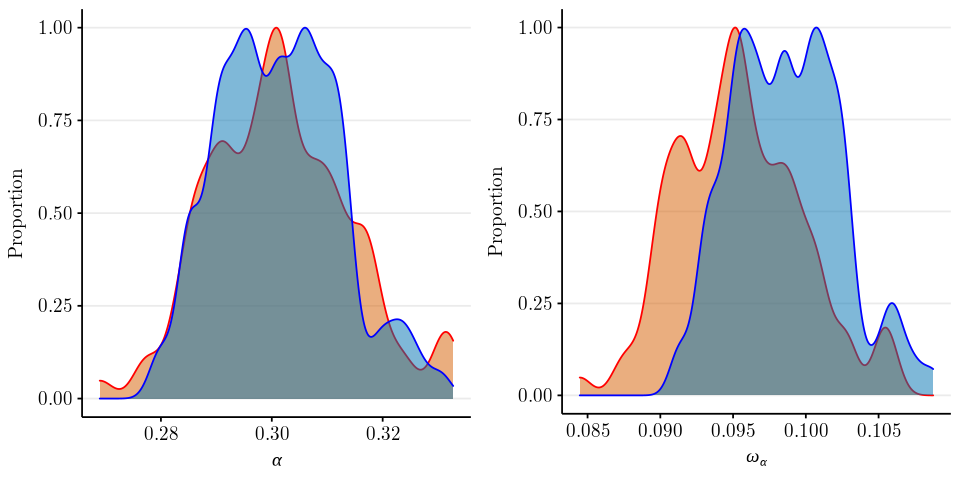

In [4]:
#plot by quantile
plots<-c()
dst_plt <- c()
fig(8,4)
values <-  c("alpha", "omega")
ylabels <-  c(expression(alpha), expression(omega[alpha]))
tags <- c("B","C")
for (i in seq(1,2)){
    summary <- df %>% group_by(group) %>% summarize(median = median(eval(as.name(values[i]))),
                                                   sd = sd(eval(as.name(values[i]))),
                                                   lower_CI = quantile(eval(as.name(values[i])), 0.05),
                                                   upper_CI = quantile(eval(as.name(values[i])), 0.95))
    
    p <- ggplot(summary, aes(x=group, y=median, ymin=lower_CI, ymax=upper_CI, colour = group, group = 1)) +
    ylim(min(df[,values[i]]), max(df[,values[i]]))+
    geom_errorbar(aes(width = 0.05)) +
    geom_point(size = 2)+
    labs(x="group", y = ylabels[i], tag = tags[i])+
    theme_latex(base_size = 18) + 
    theme(panel.grid.major.x = element_blank(),
          legend.position = "none", 
          axis.title.y = element_text(family = "sans"),
          plot.tag = element_text(face = 'bold'))
    plots[[values[i]]] <- ggplotGrob(p)
    
    #plots the distribution of alpha and omega values
    p<-ggplot(df, aes(x=eval(as.name(values[i])), color=group, fill = group)) + 
        geom_density(adjust = 0.5, alpha = 0.5, mapping = (aes(y = ..scaled..))) +
        theme_classic() +
        scale_color_manual(values=c('red','blue'))+
        labs(x=ylabels[i], y = "Proportion") + 
        theme_latex(base_size = 14) + 
        theme (panel.grid.major.x = element_blank(), legend.position = "none", 
          axis.title.x = element_text(family = "sans"))
    dst_plt[[values[i]]] <- ggplotGrob(p)
    
    }

grid.arrange(plots[['alpha']], plots[['omega']], ncol=2, nrow=1)
grid.arrange(dst_plt[['alpha']], dst_plt[['omega']], ncol=2, nrow=1)

In [5]:
tmp <- tidyr::gather(df, "NeS_0_1", "NeS_1_10", "NeS_10_100", "NeS_100_99", key = "NeS_bins", value = "DFE") %>% 
        select(group, NeS_bins, DFE) %>%
        group_by(group, NeS_bins) %>%
        summarize(median = median(DFE),
                  lower_CI = quantile(DFE, 0.05),
                  upper_CI = quantile(DFE, 0.95))
tmp$NeS_bins <- factor(tmp$NeS_bins, levels = c("NeS_0_1", "NeS_1_10", "NeS_10_100", "NeS_100_99"))

fig(6,4)
p<- ggplot(tmp, aes(x=NeS_bins, y=median, fill=group)) + 
  geom_bar(stat="identity", color="black", 
           position=position_dodge()) +
  geom_errorbar(aes(ymin=lower_CI, ymax=upper_CI), width=.2,
                 position=position_dodge(.9))+
    labs(x="NeS bins", y = "DFE", tag = "A") +
    scale_x_discrete(labels=c("0-1", "1-10", "10-100", ">100"))+
    theme_latex(base_size = 18) + 
    theme(panel.grid.major.x = element_blank(), 
          legend.position = "none", 
         plot.tag = element_text(face = 'bold'))
plots[['DFE']] <- p

`summarise()` has grouped output by 'group'. You can override using the `.groups` argument.



png 
  2

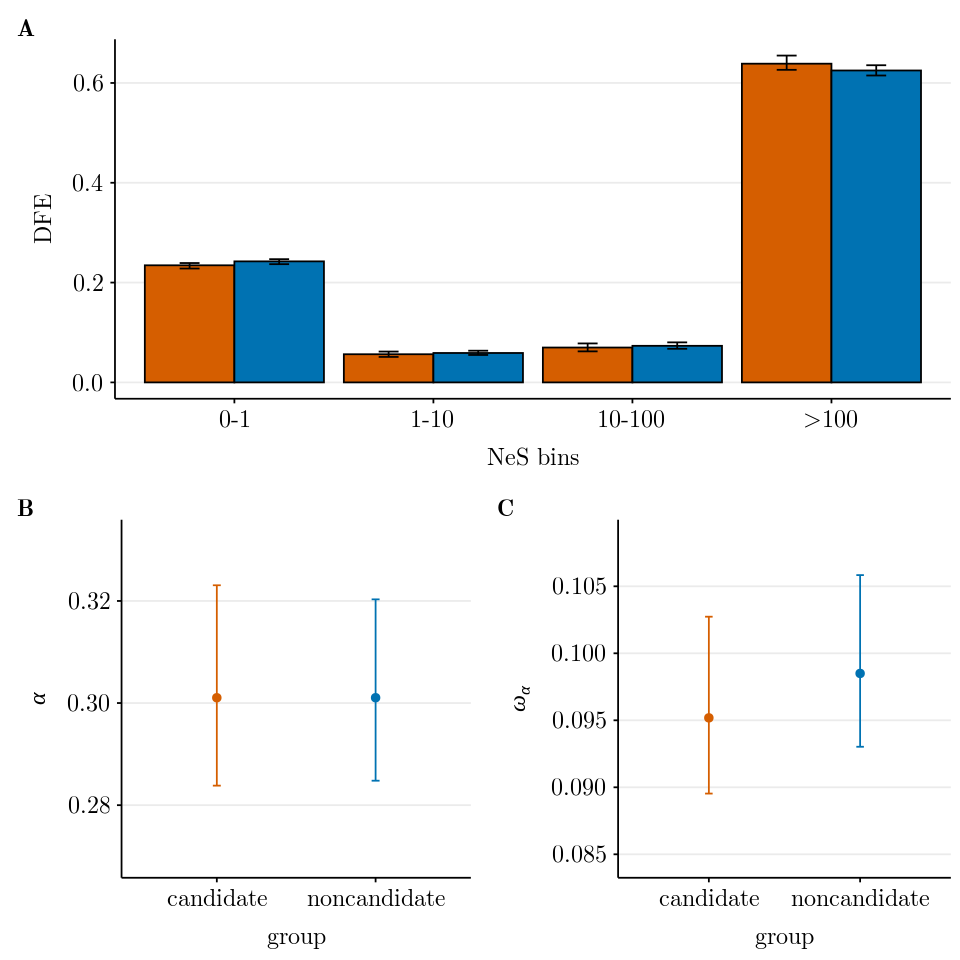

In [6]:
fig(8,8)
lay <- rbind(c(1,1),
             c(2,3))
pdf(file = boot_CI_path,  
    width = 8, 
    height = 8)
plt <- grid.arrange(plots[['DFE']], plots[['alpha']], plots[['omega']], layout_matrix = lay)
dev.off()
grid.arrange(plt)

In [7]:
#Plot distribution of DFE by NeS_bins
fig(8,10)
for (i in colnames(df[,seq((ncol(df)-3),ncol(df))])){
    
    p<- ggplot(df, aes(x=eval(as.name(i)), color=group, fill = group)) + 
        geom_density(adjust = 0.5, alpha = 0.5, mapping = (aes(y = ..scaled..))) +
        theme_classic() +
        scale_color_manual(values=c('red','blue'))+
        labs(x="DFE", y = "Proportion", title = i) + 
        theme_latex(base_size = 14) + 
        theme (panel.grid.major.x = element_blank(), legend.position = "none")
    dst_plt[[i]] <- ggplotGrob(p)
    
}

png 
  2

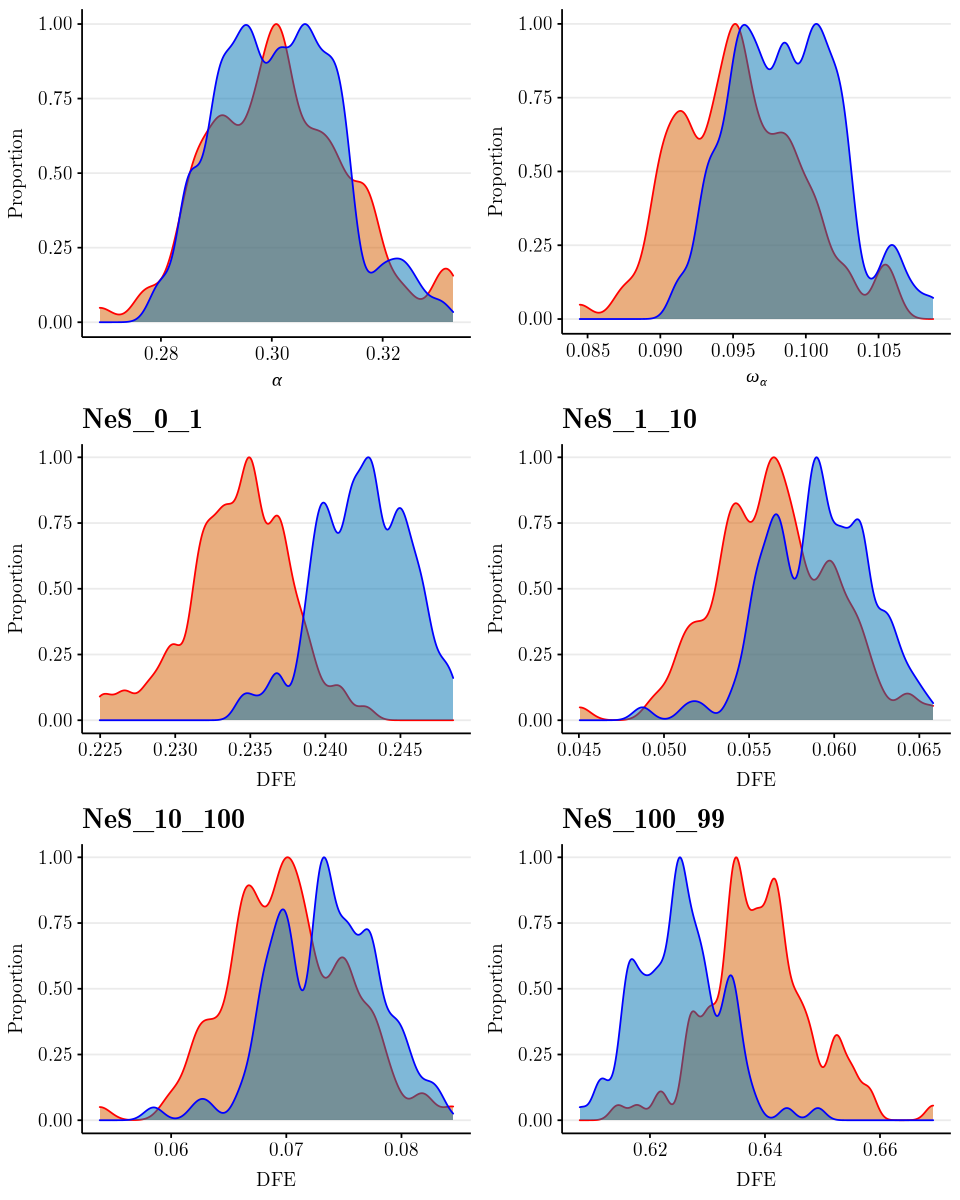

In [8]:
pdf(file = dst_path,  
    width = 8, 
    height = 10)
plt <- grid.arrange(dst_plt[["alpha"]],dst_plt[["omega"]],
                    dst_plt[["NeS_0_1"]], dst_plt[["NeS_1_10"]], 
                    dst_plt[["NeS_10_100"]], dst_plt[["NeS_100_99"]], ncol=2, nrow=3)

dev.off()
grid.arrange(plt)